# Implementing a GNN 
*without PyTorch Geometric

In [78]:
import wntr
import pandas as pd
import numpy as np
import pickle
import networkx as nx

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

(<matplotlib.collections.PathCollection at 0x2b185b21e20>,
 <matplotlib.collections.LineCollection at 0x2b185b23a00>)

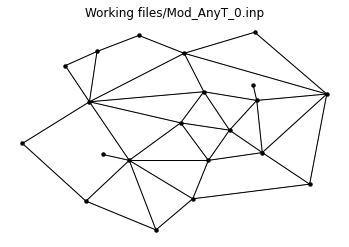

In [79]:
# Create a water network model
inp_file = 'Working files/Mod_AnyT_0.inp'
wn_current_WDS = wntr.network.WaterNetworkModel(inp_file)

# Graph the network
wntr.graphics.plot_network(wn_current_WDS, title=wn_current_WDS.name)


In [80]:
S_matrices = []
res_index = []

In [81]:
database = pickle.load( open( "Mod_AnyT_DB.p", "rb" ) )
for i in range(len(database)):
    diams = dict(zip(wn_current_WDS.link_name_list, list(database.loc[i]['Diams']))) #diam
    G_WDS = wn_current_WDS.get_graph(link_weight=diams) # directed multigraph
    A_WDS = nx.adjacency_matrix(G_WDS)
    S_matrices.append(A_WDS.todense())
    
    res_index.append(database.loc[i]['avgPrPa'])
    

In [82]:
S_matrices = torch.tensor(np.array(S_matrices), dtype = torch.float32)
res_index = torch.tensor(np.array(res_index), dtype = torch.float32)

In [83]:
demands=[]
for i in wn_current_WDS.node_name_list:
    a = wn_current_WDS.get_node(i)
    try:
        demands.append(a.base_demand)
    except Exception as e:
        demands.append(-a.base_head)  #demands.append(0)
        print(e)

'Reservoir' object has no attribute 'base_demand'
'Reservoir' object has no attribute 'base_demand'


In [135]:
class GNN(nn.Module):
    def __init__(self):  #second_filter = False
        super(GNN, self).__init__()
        
        #self.second_filter = second_filter
        
        self.h_1_0 = nn.Parameter(torch.tensor(0.004))
        self.h_1_1 = nn.Parameter(torch.tensor(0.002))
        self.h_1_2 = nn.Parameter(torch.tensor(0.001))
        
        self.fc = nn.Linear(21, 1)
        #if second_filter:
        self.h_2_0 = nn.Parameter(torch.tensor(0.004))
        self.h_2_1 = nn.Parameter(torch.tensor(0.002))
        self.h_2_2 = nn.Parameter(torch.tensor(0.001))
        
    #def graph_filter(self, S, x, ):
        
    def forward(self, S, x):
        
        f1 =  self.h_1_0 * torch.matmul(torch.pow(S, 0), x)
        f1 += self.h_1_1 * torch.matmul(torch.pow(S, 1), x)
        f1 += self.h_1_2 * torch.matmul(torch.pow(S, 2), x)
        
        f1 = torch.sigmoid(f1)
        
        #if self.second_filter:
        f2 =  self.h_2_0 * torch.matmul(torch.pow(S, 0), f1)
        f2 += self.h_2_1 * torch.matmul(torch.pow(S, 1), f1)
        f2 += self.h_2_2 * torch.matmul(torch.pow(S, 2), f1)
        
        f2 = torch.sigmoid(f2)
        
        ans = self.fc(f2)
        
        ans = torch.tanh(ans)
        #ans = torch.sigmoid(ans)
        
        #ans = torch.relu(ans)
        
        return ans

In [136]:
model = GNN() #second_filter=True

In [137]:
for i in model.parameters():
    print(i)

Parameter containing:
tensor(0.0040, requires_grad=True)
Parameter containing:
tensor(0.0020, requires_grad=True)
Parameter containing:
tensor(0.0010, requires_grad=True)
Parameter containing:
tensor(0.0040, requires_grad=True)
Parameter containing:
tensor(0.0020, requires_grad=True)
Parameter containing:
tensor(0.0010, requires_grad=True)
Parameter containing:
tensor([[ 0.1672,  0.1341, -0.2178, -0.1911, -0.0397,  0.1864, -0.0903, -0.1293,
          0.0239,  0.1511,  0.1272, -0.0712, -0.2104, -0.1543, -0.0488, -0.1915,
          0.1370,  0.1420, -0.0261,  0.1547, -0.0669]], requires_grad=True)
Parameter containing:
tensor([0.0038], requires_grad=True)


In [138]:
S = torch.tensor(np.array(A_WDS.todense()), dtype = torch.float32)
x = torch.tensor(np.array(demands), dtype = torch.float32)

In [139]:
x

tensor([ 3.1545e-02,  1.2618e-02,  1.2618e-02,  1.2618e-02,  0.0000e+00,
         3.1545e-02,  3.1545e-02,  0.0000e+00,  3.1545e-02,  6.3090e-02,
         3.1545e-02,  3.1545e-02,  0.0000e+00,  1.2618e-02,  1.2618e-02,
         1.2618e-02,  1.2618e-02,  5.0472e-02,  1.2618e-02, -6.5532e+01,
        -6.5532e+01])

In [140]:
model(S_matrices[9], x)

tensor([-0.1018], grad_fn=<TanhBackward>)

In [141]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = GNN().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)


In [142]:
training_range = 4000
test_range = 1000

In [143]:
for epoch in range(51):
    total_loss= 0
#     total_correct =0
    #Data
    for i in range(training_range):
        #Prediction
        preds = model(S_matrices[i], x)
        labels = res_index[i]

        #Calculate the loss
        loss = F.mse_loss(preds, labels) 

        #Backpropagate
        optimizer.zero_grad() #To avoid adding up gradients
        loss.backward() #calculate gradients

        #Optimizer step
        optimizer.step() #Update weights

        total_loss += loss.item()
#         total_correct += get_number_correct_labels(preds, labels)
    if epoch%10 ==0:
        print("epoch ", epoch, " total loss  ", total_loss )

<ipython-input-143-373740454336>:11: UserWarning: Using a target size (torch.Size([])) that is different to the input size (torch.Size([1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  loss = F.mse_loss(preds, labels)


epoch  0  total loss   65.80210703177937
epoch  10  total loss   104.59610640873629
epoch  20  total loss   95.49060438328391
epoch  30  total loss   68.84230053720593
epoch  40  total loss   104.63379036669718
epoch  50  total loss   68.27981141407837


In [144]:
for i in model.parameters():
    print(i)

Parameter containing:
tensor(-0.3027, requires_grad=True)
Parameter containing:
tensor(7.9371e-06, requires_grad=True)
Parameter containing:
tensor(0.0607, requires_grad=True)
Parameter containing:
tensor(-0.3121, requires_grad=True)
Parameter containing:
tensor(-0.1279, requires_grad=True)
Parameter containing:
tensor(-0.2966, requires_grad=True)
Parameter containing:
tensor([[-0.1248, -0.1326, -0.0634, -0.0873, -0.1297, -0.1284, -0.0310, -0.0410,
         -0.0793,  0.0105, -0.1451, -0.1112, -0.0427, -0.1266, -0.1319, -0.1183,
         -0.0780, -0.1635, -0.0722, -0.0410, -0.1995]], requires_grad=True)
Parameter containing:
tensor([0.3632], requires_grad=True)


In [145]:
preds

tensor([0.3462], grad_fn=<TanhBackward>)

In [146]:
model(S_matrices[95],x)

tensor([0.3479], grad_fn=<TanhBackward>)

In [147]:
res_index[95]

tensor(0.4141)

In [148]:
total_loss/training_range

0.01706995285351959

In [149]:
loss_dev = 0
for i in range(training_range,training_range+test_range):
    #Prediction
    preds = model(S_matrices[i], x)
    labels = res_index[i]
    print(np.round(preds.item(), 4), labels)
    #Calculate the loss
    loss_dev += F.mse_loss(preds, labels.reshape(1))

print(loss_dev/test_range)

0.3479 tensor(0.4008)
0.3479 tensor(0.1595)
0.3479 tensor(0.3524)
0.3479 tensor(0.4565)
0.3479 tensor(0.4069)
0.3479 tensor(0.3403)
0.3479 tensor(0.3723)
0.3479 tensor(0.1786)
0.3479 tensor(0.3115)
0.3479 tensor(0.4135)
0.3479 tensor(0.3659)
0.3479 tensor(0.2052)
0.3479 tensor(0.3923)
0.3479 tensor(0.3494)
0.3479 tensor(0.3278)
0.3479 tensor(0.4150)
0.3479 tensor(0.4104)
0.3479 tensor(0.3042)
0.3479 tensor(0.4668)
0.3479 tensor(0.3735)
0.3479 tensor(0.2731)
0.3479 tensor(0.2628)
0.3479 tensor(0.3442)
0.3479 tensor(0.3981)
0.3479 tensor(-0.1533)
0.3479 tensor(-0.1327)
0.3479 tensor(0.3802)
0.3479 tensor(0.4245)
0.3479 tensor(0.4533)
0.3479 tensor(0.4602)
0.3479 tensor(0.4536)
0.3479 tensor(0.3795)
0.3479 tensor(0.3024)
0.3479 tensor(0.3857)
0.3479 tensor(0.4579)
0.3479 tensor(0.3214)
0.3479 tensor(0.2902)
0.3479 tensor(0.4900)
0.3479 tensor(0.3988)
0.3479 tensor(0.3914)
0.3479 tensor(0.3195)
0.3479 tensor(0.4471)
0.3479 tensor(0.1125)
0.3479 tensor(0.3990)
0.3479 tensor(0.3093)
0.3479 t

In [150]:
torch.sum(res_index)/5000

tensor(0.3551)